In [2]:
import sys
sys.path.append('/../../QmeQ/qmeq/')
import qmeq

from scipy.linalg import eig, eigvals
import numpy as np

import matplotlib.pyplot as plt

In [3]:
# Anderson dot model (from qmeq tutorial)

# Quantum dot parameters
vgate = 0.0
bfield = 0.001
omega = .1
U = 20.0


# Lead parameters
vbias = 0.5
temp = 1.0
dband = 100.0
# Tunneling amplitudes
gam = 0.5
t0 = np.sqrt(gam/(2*np.pi))

nsingle = 2

# 0 is up, 1 is down
hsingle = {(0, 0): vgate+bfield/2,
           (1, 1): vgate-bfield/2,
           (0, 1): omega}

coulomb = {(0,1,1,0):U}

tleads = {(0, 0):t0, # L, up   <-- up
          (1, 0):t0, # R, up   <-- up
          (2, 1): 2 * t0, # L, down <-- down         
          (3, 1): 2* t0} # R, down <-- down
                     # lead label, lead spin <-- level spin

nleads = 4

#        L,up        R,up         L,down      R,down
mulst = {0: vbias/2, 1: -vbias/2, 2: vbias/2, 3: -vbias/2}
tlst =  {0: temp,    1: temp,     2: temp,    3: temp}



sys = qmeq.Builder(nsingle, hsingle, coulomb,
                      nleads, tleads, mulst, tlst, dband, countingleads = [0,2],
                      kerntype='py1vN', itype = 1)

# make sure the kernel does not get overwritten
sys.make_kern_copy = True

sys.solve()

In [6]:
liouvillian = sys.kern
print(liouvillian.shape)
#print(liouvillian)

(6, 6)


In [7]:
# calculate eigenvalues, left and right eigenvalues
eval_j, left_ev, right_ev = eig(liouvillian, left = True) 

# sort eigenvalues/eigenvectors
idx = eval_j.argsort()[::-1]   
eval_j = eval_j[idx]
left_ev = left_ev[:,idx]
right_ev = right_ev[:,idx] 

In [9]:
result = np.zeros((6,6)) + 0j

for j in range(6):
    for k in range(6):
        result[j,k] = np.dot(np.conjugate(left_ev[:,j]),right_ev[:,k])
        # normalization to 1
        if j == k:
            result[j,k] = result[j,k]/np.dot(np.conjugate(left_ev[:,j]),right_ev[:,k])
            
#print(str(np.round(np.real(result),1)))

In [10]:
np.real(np.round(2 * left_ev[:,0],0))

array([1., 1., 1., 1., 0., 0.])

In [11]:
# definie initial state
initial = np.array([1,0,0,0,0,0])

# calculate stationary state from left/right eigenvectors
rho_ss = 1/np.dot((left_ev[:,0]),right_ev[:,0]) * np.dot(np.conjugate(left_ev[:,0]), initial) * right_ev[:,0]


print('rho_ss from left/right eigenvectors: \n' + str(rho_ss))
print(' \n qmeq solution rho_ss: \n' + str(sys.phi0))
print(' \n difference: ' + str(np.round(sys.phi0 - rho_ss,10).real) )

rho_ss from left/right eigenvectors: 
[ 3.34519464e-01+0.j  3.46476800e-01+0.j  3.18988119e-01+0.j
  1.56170598e-05+0.j -4.20054452e-03+0.j  1.62122212e-02+0.j]
 
 qmeq solution rho_ss: 
[ 3.34519464e-01  3.46476800e-01  3.18988119e-01  1.56170598e-05
 -4.20054452e-03  1.62122212e-02]
 
 difference: [0. 0. 0. 0. 0. 0.]


In [12]:
#FULL TIME EVOLUTION:

# define time grid
ti_array = np.linspace(0,10,500)

#dimension
dim = liouvillian.shape[0]

rho_t = np.zeros((dim,ti_array.shape[0])) + 0j

# calculate elements and perform sum
for i in range(dim-1):
    norm = np.dot(np.conjugate(left_ev[:,i+1]),right_ev[:,i+1])
    rho_t += 1/norm * np.dot(np.conjugate(left_ev[:,i+1]), initial) * np.exp(eval_j[i+1] *  ti_array[None,:]) * right_ev[:,i+1,None] 

#add stationary state    
rho_t = rho_t + rho_ss[:,None]

print(rho_t.shape)

(6, 500)


Text(0, 0.5, '$\\rho(t)$')

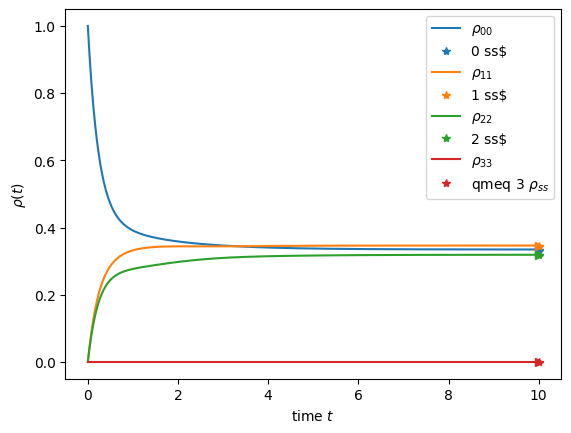

In [16]:
#EVOLUTION OF DIAGONAL COMPONENTS

plt.plot(ti_array, np.real(rho_t[0]), label = r'$\rho_{00}$')
plt.plot(ti_array[-1],sys.phi0[0], '>',color = 'C0')
plt.plot(ti_array[-1],sys.phi0[0], '*',color = 'C0', label = r'0 ss$')

plt.plot(ti_array, np.real(rho_t[1]), label = r'$\rho_{11}$')
plt.plot(ti_array[-1],sys.phi0[1], '>',color = 'C1')
plt.plot(ti_array[-1],sys.phi0[1], '*',color = 'C1', label = r'1 ss$')


plt.plot(ti_array, np.real(rho_t[2]), label = r'$\rho_{22}$')
plt.plot(ti_array[-1],sys.phi0[2], '>',color = 'C2')
plt.plot(ti_array[-1],sys.phi0[2], '*',color = 'C2', label = r'2 ss$')



plt.plot(ti_array, np.real(rho_t[3]), label = r'$\rho_{33}$')
plt.plot(ti_array[-1],sys.phi0[3], '*',color = 'C3', label = r'qmeq 3 $\rho_{ss}$')
plt.plot(ti_array[-1],sys.phi0[3], '>',color = 'C3')

plt.legend()

plt.xlabel(r'time $t$')
plt.ylabel(r'$\rho(t)$')

In [ ]:
#EVOLUTION OF OFF DIAGONAL COMPONENTS

plt.plot(ti_array, np.real(rho_t[4]), label = r'Re[$\rho_{12}$]')
plt.plot(ti_array[-1],sys.phi0[4], '>',color = 'C0')



plt.plot(ti_array, np.real(rho_t[5]), label = r'Im[$\rho_{12}$]')
plt.plot(ti_array[-1],sys.phi0[5], '>',color = 'black', label = r'qmeq $\rho_{ss}$')
plt.plot(ti_array[-1],sys.phi0[5], '>',color = 'C1')

plt.legend()

plt.xlabel(r'time $t$')
plt.ylabel(r'$\rho(t)$')

In [17]:
# PARTICLE CURRENT

# transient current

# qmeq solution for stationary current 
I_ss = sys.current

I_t_qmeq = np.zeros((nleads,ti_array.shape[0]))
I_t_CF = np.zeros((ti_array.shape[0]))


for i in range(ti_array.shape[0]):
    
    # reset current    
    sys.current[:] = np.zeros(nleads)
    
    # set stationary state to rho_t value
    sys.phi0[:] = np.real(rho_t[:,i])
    
    # calculate current (also calculates energy and heat currents)
    sys.appr.generate_current() # calculates current both ways
    I_t_qmeq[:,i] = sys.current
    I_t_CF[i] = sys.current_noise[0] 
    
    #--------------------------------------------
    
# combine contributions from left and right lead    
IL_t_qmeq = I_t_qmeq[0] + I_t_qmeq[2]
IR_t_qmeq = I_t_qmeq[1] + I_t_qmeq[3]

Text(0, 0.5, '$I(t)$')

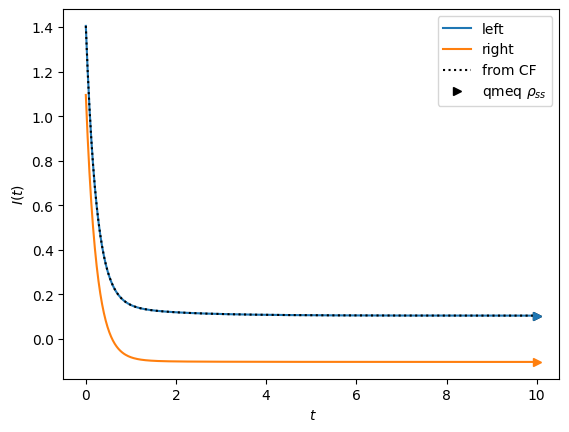

In [ ]:
#plotting particle current

plt.plot(ti_array,IL_t_qmeq , label = 'left')
plt.plot(ti_array, IR_t_qmeq ,label = 'right')
plt.plot(ti_array[-1], (I_ss[1] + I_ss[3]), '>', color = 'C1' , )

plt.plot(ti_array, I_t_CF, ':', color = 'black', label = r'from CF')

plt.plot(ti_array[-1], I_ss[0] + I_ss[2],'>',color = 'black', label = r'qmeq $\rho_{ss}$')
plt.plot(ti_array[-1], I_ss[0] + I_ss[2], '>', color = 'C0', )

plt.legend()

plt.xlabel(r' $t$')
plt.ylabel(r'$I(t)$')